In [9]:
%matplotlib inline
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from numpy import genfromtxt
import pywt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import covariance as cov
import spm1d.stats as spm
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from itertools import chain, combinations
import scipy
from collections import Counter
from ggplot import *


class_names = []
images_count = 16
window = 300

In [10]:
def get_list_of_files():
    files_list = [x for x in os.listdir("stas_data") if x.endswith('.csv')]
    return files_list

def get_initial_data_frame():
    files = get_list_of_files()
    df = pd.concat((pd.read_csv("stas_data/" + f) for f in files), ignore_index = True)
    return (df)

In [11]:
stas_df = get_initial_data_frame()

In [12]:
stas_df.head()

,el1,el2,el3,el4,quality1,quality2,quality3,quality4,name,imageID,imageSTEP
0,878.419,847.164,868.549,870.194,1,1,1,1,stas18.08morning978307200.0,0,1
1,850.454,843.874,860.324,817.555,1,1,1,1,stas18.08morning978307200.0,0,1
2,865.259,850.454,866.904,843.874,1,1,1,1,stas18.08morning978307200.0,0,1
3,878.419,848.809,861.969,896.514,1,1,1,1,stas18.08morning978307200.0,0,1
4,871.839,847.164,861.969,896.514,1,1,1,1,stas18.08morning978307200.0,0,1


In [13]:
def rms(coef):
    return(np.sqrt(np.sum(np.square(coef)) / len(coef)))

def aac(coef):
    return(np.sum(np.abs(np.diff(coef)))/(len(coef) - 1))

def ssi(coef):
    return(np.sum(np.square(np.abs(coef))))

def ieeg(coef):
    return(np.sum(np.abs(coef)))

In [14]:
def feature_extraction_with_wavelets(df, wavelet_name, full = True, is_it_training = True, number_of_people = -1, images_range = range(images_count)):
    data = np.array([])
    target = np.array([])
    
    groups = np.unique(df['name'])
    if(number_of_people > 0 and number_of_people < len(groups)):
        groups = groups[0:number_of_people]
    
    for person in groups:
        cur_df = df[df['name'] == person]
        
        for image_num in images_range:
            cur_image_df = cur_df[cur_df['imageID'] == image_num]
            
            if (not full):
                if (is_it_training):
                    cur_image_df = cur_image_df[cur_image_df['imageSTEP'] < 3]
                else:
                     cur_image_df = cur_image_df[cur_image_df['imageSTEP'] >= 3]
                    
            if (cur_image_df.shape[0] == 0):
                continue
                
            for i in range(0, cur_image_df.shape[0] - window + 1, 100):
                ch_1 = cur_image_df['el1'][i:(i+window)]
                ch_2 = cur_image_df['el2'][i:(i+window)]
                ch_3 = cur_image_df['el3'][i:(i+window)]
                ch_4 = cur_image_df['el4'][i:(i+window)]
                
                dwt_coeffs1 = pywt.wavedec(ch_1, wavelet_name, level = 4)
                dwt_coeffs2 = pywt.wavedec(ch_2, wavelet_name, level = 4)
                dwt_coeffs3 = pywt.wavedec(ch_3, wavelet_name, level = 4)
                dwt_coeffs4 = pywt.wavedec(ch_4, wavelet_name, level = 4)
            
                new_line = [max(dwt_coeffs1[1]), max(dwt_coeffs1[2]), max(dwt_coeffs1[3]), max(dwt_coeffs1[4]),
                            max(dwt_coeffs2[1]), max(dwt_coeffs2[2]), max(dwt_coeffs2[3]), max(dwt_coeffs2[4]),
                            max(dwt_coeffs3[1]), max(dwt_coeffs3[2]), max(dwt_coeffs3[3]), max(dwt_coeffs3[4]),
                            max(dwt_coeffs4[1]), max(dwt_coeffs4[2]), max(dwt_coeffs4[3]), max(dwt_coeffs4[4]),
                            min(dwt_coeffs1[1]), min(dwt_coeffs1[2]), min(dwt_coeffs1[3]), min(dwt_coeffs1[4]),
                            min(dwt_coeffs2[1]), min(dwt_coeffs2[2]), min(dwt_coeffs2[3]), min(dwt_coeffs2[4]),
                            min(dwt_coeffs3[1]), min(dwt_coeffs3[2]), min(dwt_coeffs3[3]), min(dwt_coeffs3[4]),
                            min(dwt_coeffs4[1]), min(dwt_coeffs4[2]), min(dwt_coeffs4[3]), min(dwt_coeffs4[4]),
                            np.std(dwt_coeffs1[1]), np.std(dwt_coeffs1[2]), np.std(dwt_coeffs1[3]), np.std(dwt_coeffs1[4]),
                            np.std(dwt_coeffs2[1]), np.std(dwt_coeffs2[2]), np.std(dwt_coeffs2[3]), np.std(dwt_coeffs2[4]),
                            np.std(dwt_coeffs3[1]), np.std(dwt_coeffs3[2]), np.std(dwt_coeffs3[3]), np.std(dwt_coeffs3[4]),
                            np.std(dwt_coeffs4[1]), np.std(dwt_coeffs4[2]), np.std(dwt_coeffs4[3]), np.std(dwt_coeffs4[4]),
                            rms(dwt_coeffs1[1]), rms(dwt_coeffs1[2]), rms(dwt_coeffs1[3]), rms(dwt_coeffs1[4]),
                            rms(dwt_coeffs2[1]), rms(dwt_coeffs2[2]), rms(dwt_coeffs2[3]), rms(dwt_coeffs2[4]),
                            rms(dwt_coeffs3[1]), rms(dwt_coeffs3[2]), rms(dwt_coeffs3[3]), rms(dwt_coeffs3[4]),
                            rms(dwt_coeffs4[1]), rms(dwt_coeffs4[2]), rms(dwt_coeffs4[3]), rms(dwt_coeffs4[4]),
                            aac(dwt_coeffs1[1]), aac(dwt_coeffs1[2]), aac(dwt_coeffs1[3]), aac(dwt_coeffs1[4]),
                            aac(dwt_coeffs2[1]), aac(dwt_coeffs2[2]), aac(dwt_coeffs2[3]), aac(dwt_coeffs2[4]),
                            aac(dwt_coeffs3[1]), aac(dwt_coeffs3[2]), aac(dwt_coeffs3[3]), aac(dwt_coeffs3[4]),
                            aac(dwt_coeffs4[1]), aac(dwt_coeffs4[2]), aac(dwt_coeffs4[3]), aac(dwt_coeffs4[4]),
                            ssi(dwt_coeffs1[1]), ssi(dwt_coeffs1[2]), ssi(dwt_coeffs1[3]), ssi(dwt_coeffs1[4]),
                            ssi(dwt_coeffs2[1]), ssi(dwt_coeffs2[2]), ssi(dwt_coeffs2[3]), ssi(dwt_coeffs2[4]),
                            ssi(dwt_coeffs3[1]), ssi(dwt_coeffs3[2]), ssi(dwt_coeffs3[3]), ssi(dwt_coeffs3[4]),
                            ssi(dwt_coeffs4[1]), ssi(dwt_coeffs4[2]), ssi(dwt_coeffs4[3]), ssi(dwt_coeffs4[4]),
                            ieeg(dwt_coeffs1[1]), ieeg(dwt_coeffs1[2]), ieeg(dwt_coeffs1[3]), ieeg(dwt_coeffs1[4]),
                            ieeg(dwt_coeffs2[1]), ieeg(dwt_coeffs2[2]), ieeg(dwt_coeffs2[3]), ieeg(dwt_coeffs2[4]),
                            ieeg(dwt_coeffs3[1]), ieeg(dwt_coeffs3[2]), ieeg(dwt_coeffs3[3]), ieeg(dwt_coeffs3[4]),
                            ieeg(dwt_coeffs4[1]), ieeg(dwt_coeffs4[2]), ieeg(dwt_coeffs4[3]), ieeg(dwt_coeffs4[4])]
                
                new_line = np.array(new_line)
                line_class = person
            
                if (data.size == 0):
                    data = np.array(new_line)
                else:
                    data = np.vstack((data, new_line))
                if (target.size == 0):
                    target = np.array(line_class)
                else:
                    target = np.vstack((target, line_class))
    
    
    data = np.asmatrix(data)
    target = np.asmatrix(target)
    data_df = pd.DataFrame()

    if (data.shape[0] > 0 and data.shape[1] > 0):
        data_df = pd.DataFrame(data = data[0:,0:])
        
    data_df.columns = ['max11', 'max12','max13','max14',
                       'max21', 'max22','max23','max24',
                       'max31', 'max32','max33','max34',
                       'max41', 'max42','max43','max44',
                       'min11', 'min12','min13','min14',
                       'min21', 'min22','min23','min24',
                       'min31', 'min32','min33','min34',
                       'min41', 'min42','min43','min44',
                       'sd11', 'sd12','sd13','sd14',
                       'sd21', 'sd22','sd23','sd24',
                       'sd31', 'sd32','sd33','sd34',
                       'sd41', 'sd42','sd43','sd44',
                       'rms11', 'rms12','rms13','rms14',
                       'rms21', 'rms22','rms23','rms24',
                       'rms31', 'rms32','rms33','rms34',
                       'rms41', 'rms42','rms43','rms44',
                       'aac11', 'aac12','aac13','aac14',
                       'aac21', 'aac22','aac23','aac24',
                       'aac31', 'aac32','aac33','aac34',
                       'aac41', 'aac42','aac43','aac44',
                       'ssi11', 'ssi12','ssi13','ssi14',
                       'ssi21', 'ssi22','ssi23','ssi24',
                       'ssi31', 'ssi32','ssi33','ssi34',
                       'ssi41', 'ssi42','ssi143','ssi44',
                       'ieeg11', 'ieeg12','ieeg13','ieeg14',
                       'ieeg21', 'ieeg22','ieeg23','ieeg24',
                       'ieeg31', 'ieeg32','ieeg33','ieeg34',
                       'ieeg41', 'ieeg42','ieeg43','ieeg44']
    target_df = pd.DataFrame(data = target, columns = ['id'])
    return(data_df, target_df)

def mix_dataset(data, target):
    df_all = pd.concat([data, target], axis = 1)
    df_all = df_all.sample(frac=1).reset_index(drop=True)
    return (df_all.iloc[:,:-1], df_all.iloc[:,-1])

stas18.08morning978307200.0
stas19ifree978307200.0
stas22.08morningAfterBreakfast978307200.0
stas23.08morningafterbigbreakfast978307200.0
stas25.08lightbreakfast978307200.0
stas29.08smallbrrakfast978307200.0


/Users/Vladimir/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


stas30.08beforelanch978307200.0


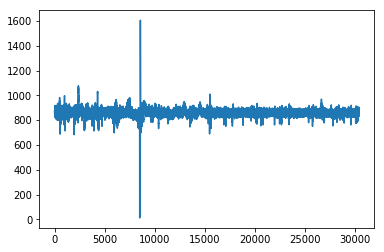

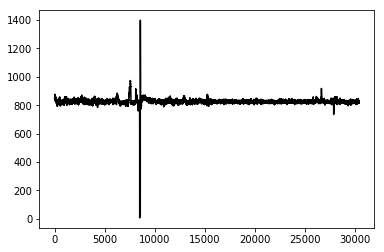

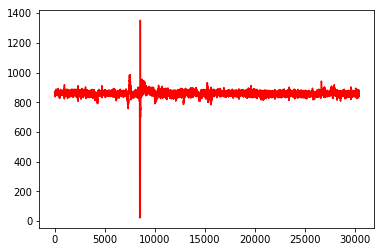

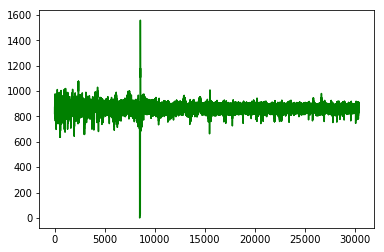

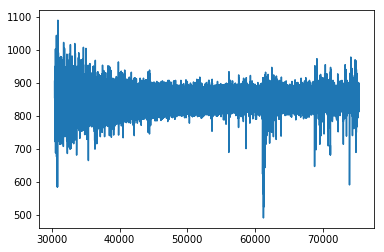

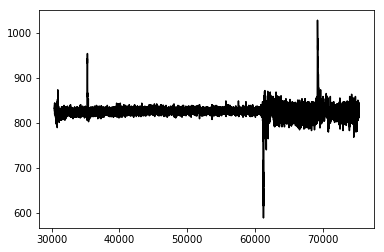

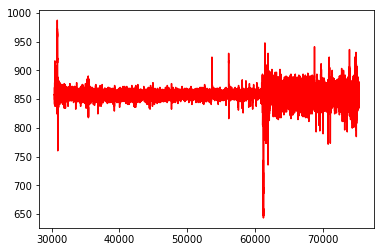

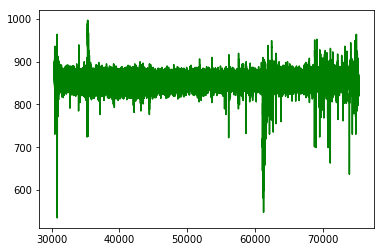

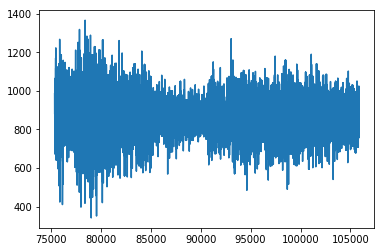

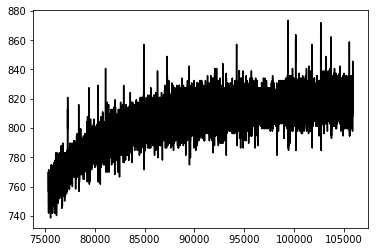

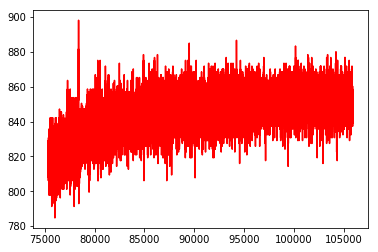

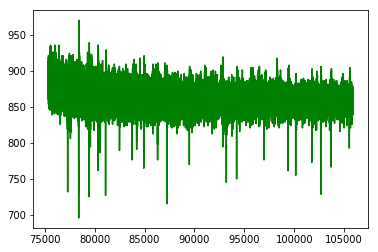

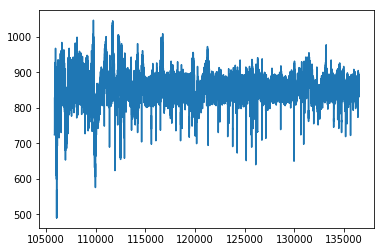

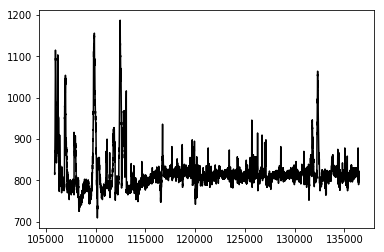

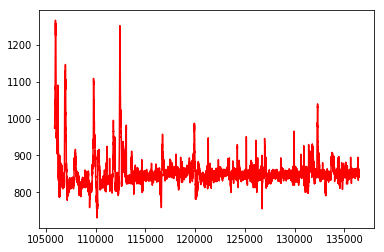

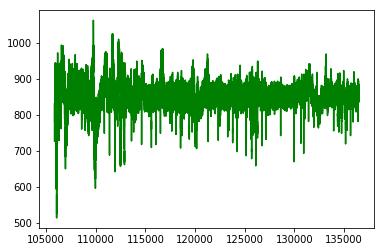

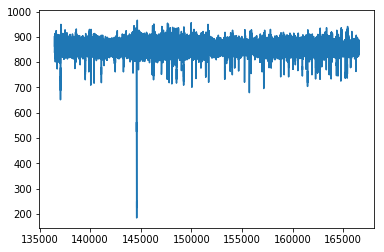

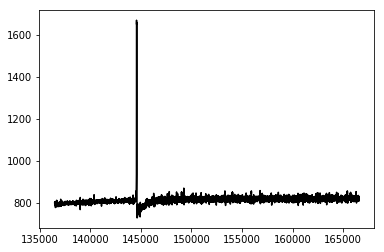

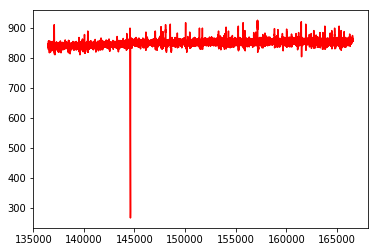

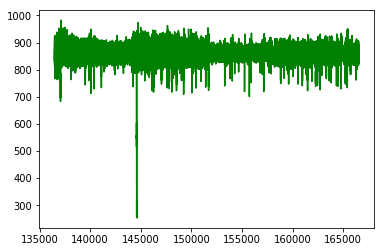

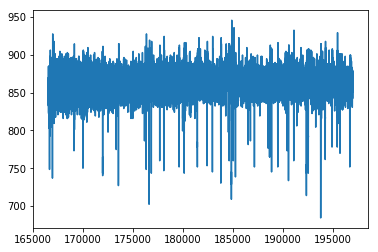

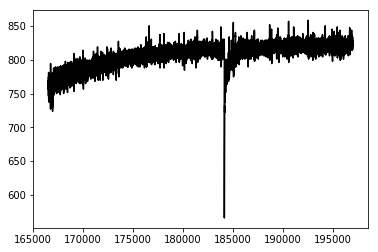

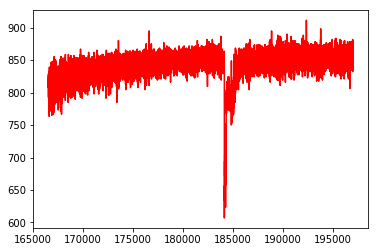

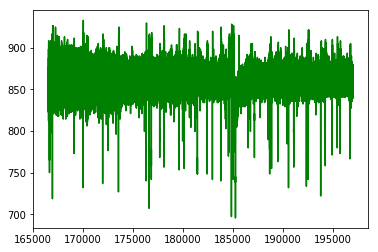

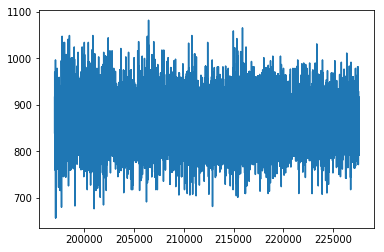

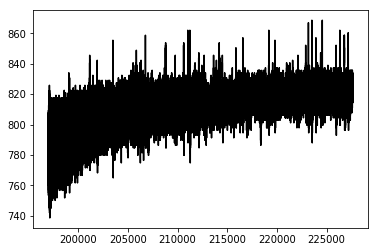

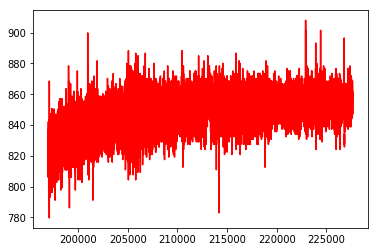

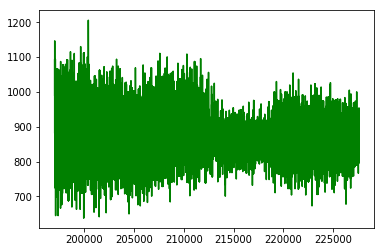

In [15]:
for person in np.unique(stas_df["name"]):
    print(person)
    plt.figure()
    plt.plot(stas_df[stas_df["name"] == person]['el1'])
    plt.figure()
    plt.plot(stas_df[stas_df["name"] == person]['el2'], color = 'black')
    plt.figure()
    plt.plot(stas_df[stas_df["name"] == person]['el3'], color = 'red')
    plt.figure()
    plt.plot(stas_df[stas_df["name"] == person]['el4'], color = 'green')

10 Features with the bigest weighs in the first component
[54 38 90 39 55 23 42 70 58 22 86 45 61  6 44]
10 Features with the bigest weighs in the second component
[82 83 66 98 34 50 67  2 99 35 51  3 18 64 97]
10 Features with the bigest weighs in the third component
[ 88 107  74  84  92  75 105  43  59  73 106  36  52  20   4]
10 features which correlate the most with 3 components
[32 33 37 62 14 11 35 30 63 60  1 34 41 42 52]

10 features which correlate the most with 1 component
[32 37 11 14 21 38 43 26 31 36 20  1 44 30 12]

10 features which correlate the most with 2 component
[33 35 34 41 27 30 13 42 40 14  1  5 80  4 39]

10 features which correlate the most with 3 component
[62 63 60 52 61 53 64  1 57 48 66 55 36 47 45]

10 features which correlate the least with 3 components
[111 110 109 106 107 108  81 101 105 100  97  99  94  93 103]

10 features which correlate the least with 1 component
[109 111 106  97 110  27 108  39  94 101 107 104  81 100 105]

10 features which corre

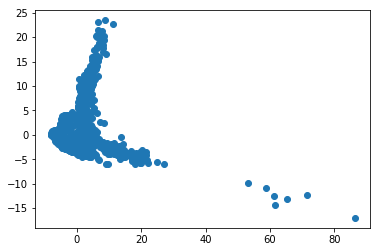

In [16]:
def pca_test(dat):
    data_scaled = preprocessing.scale(dat)
    pca = PCA()
    pca.fit(data_scaled)
    transformed_df = pca.transform(data_scaled)
    plt.plot(transformed_df[:,0], transformed_df[:,1], 'o')
    
    print("10 Features with the bigest weighs in the first component")
    print(numpy.abs(pca.components_[0]).argsort()[::-1][:15])
    print("10 Features with the bigest weighs in the second component")
    print(numpy.abs(pca.components_[1]).argsort()[::-1][:15])
    print("10 Features with the bigest weighs in the third component")
    print(numpy.abs(pca.components_[3]).argsort()[::-1][:15])
    
    print("10 features which correlate the most with 3 components")
    
    f = pca.components_.copy()
    for i in range(data_scaled.shape[1]):
        f[i,] = np.multiply(f[i,], np.sqrt(pca.explained_variance_))
    
    cors = pca.components_[0].copy()
    cors1 = pca.components_[0].copy()
    cors2 = pca.components_[0].copy()
    cors3 = pca.components_[0].copy()
    for i in range(data_scaled.shape[1]):
        cors[i] = np.sum(np.square(f[i, 0:3]))
        cors1[i] = np.sum(np.square(f[i, 0]))
        cors2[i] = np.sum(np.square(f[i, 1]))
        cors3[i] = np.sum(np.square(f[i, 2]))
        
    
    print(numpy.abs(cors).argsort()[::-1][:15])
    
    print("\n10 features which correlate the most with 1 component")
    print(numpy.abs(cors1).argsort()[::-1][:15])
    print("\n10 features which correlate the most with 2 component")
    print(numpy.abs(cors2).argsort()[::-1][:15])
    print("\n10 features which correlate the most with 3 component")
    print(numpy.abs(cors3).argsort()[::-1][:15])
    
    
    print("\n10 features which correlate the least with 3 components")
    print(numpy.abs(cors).argsort()[:15])
    print("\n10 features which correlate the least with 1 component")
    print(numpy.abs(cors1).argsort()[:15])
    print("\n10 features which correlate the least with 2 component")
    print(numpy.abs(cors2).argsort()[:15])
    print("\n10 features which correlate the least with 3 component")
    print(numpy.abs(cors3).argsort()[:15])


stas_features, stas_targets = feature_extraction_with_wavelets(stas_df, 'bior3.3')
pca_test(stas_features)

In [17]:
full_list = [x for x in os.listdir("new_data") if x.endswith('.csv')]
rest_of_the_data = pd.concat((pd.read_csv("new_data/" + f) for f in full_list), ignore_index = True)

In [18]:
rest_of_the_data = rest_of_the_data[-(rest_of_the_data["name"].isin(np.unique(stas_df["name"])))]

10 Features with the bigest weighs in the first component
[ 86  55 103  39  87  71  73   6  41   7  57  75  23  22 105]
10 Features with the bigest weighs in the second component
[66  2 18 50 34 67 98 33 64 49 97 32 19 65 51]
10 Features with the bigest weighs in the third component
[ 70 101  37  69  53  52  36 100 102  54  38  68  20  21   5]
10 features which correlate the most with 3 components
[21 22 60 14 24 20 13 19 59 30 55  8 58  6 16]

10 features which correlate the most with 1 component
[21 14 20 13  6 32  1 37 10 33 23 31 70 30  2]

10 features which correlate the most with 2 component
[22 24 19  8 30 16 25 15 21 34 10  1 18 76 14]

10 features which correlate the most with 3 component
[60 59 55 58 53 40 34  1 52 11 37  6 54  2 24]

10 features which correlate the least with 3 components
[110 111 107 106 105 104 109 108  92 101 100  95 103  45  91]

10 features which correlate the least with 1 component
[ 95 105 110 104 111 106 107 103 101  96  92  93 108 109  48]

10 featu

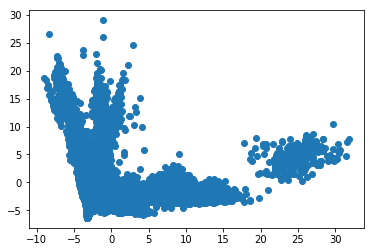

In [19]:
rest_features, rest_targets = feature_extraction_with_wavelets(rest_of_the_data, 'bior3.3')
pca_test(rest_features)

In [40]:
cors_intersection = set(range(112))
for combination in combinations(np.unique(stas_df["name"]), 2):
    print(combination)
    rows1 = stas_targets[stas_targets["id"] == combination[0]].index.values
    rows2 = stas_targets[stas_targets["id"] == combination[1]].index.values
    cors = []
    for i in range(stas_features.shape[1]):
        feature_set1 = stas_features.iloc[rows1,i]
        feature_set2 = stas_features.iloc[rows2,i]
        l = min(len(feature_set1), len(feature_set2))
        feature_set1 = feature_set1[:l]
        feature_set2 = feature_set2[:l]    
        cors.append(scipy.stats.pearsonr(feature_set1, feature_set2)[0])
    
    most_correlated = numpy.abs(cors).argsort()[::-1][:30]
    cors_intersection = cors_intersection & set(most_correlated)
    print(cors_intersection)
    print("Most correlated: \n{}\n".format(most_correlated))
    print("Correlations: \n{}\n".format(np.array(cors)[most_correlated]))
print(cors_intersection)


('stas18.08morning978307200.0', 'stas19ifree978307200.0')
{2, 3, 14, 15, 19, 30, 31, 34, 35, 46, 47, 50, 51, 62, 63, 66, 67, 71, 78, 79, 82, 83, 94, 95, 98, 99, 102, 103, 110, 111}
Most correlated: 
[ 98  67  50  34  82  99  66  35  51  83  79 111  62  46  78 110  47  63
  94  95  14  30   2 102  15  71  31   3 103  19]

Correlations: 
[ 0.8834463   0.85870678  0.8556626   0.85428485  0.81947517  0.81421418
  0.79504994  0.79096051  0.79083363  0.74706563  0.72621568  0.71361027
  0.7078998   0.70737252  0.68794068  0.6844827   0.67743968  0.67724599
  0.65641164  0.62117454  0.58996148  0.50577948  0.48968953  0.4168913
  0.41247956  0.40744843  0.37019254  0.35766908  0.32876012  0.3191069 ]

('stas18.08morning978307200.0', 'stas22.08morningAfterBreakfast978307200.0')
{2, 14, 15, 30, 31, 34, 35, 46, 47, 50, 51, 62, 63, 66, 67, 78, 79, 82, 83, 94, 95, 98, 99, 110, 111}
Most correlated: 
[ 62  46 110  94  79  95  63  47  78 111  14  30  83  82  99  31  98  51
  35  67  50  34  66  15  

In [66]:
def check_model_on_Stas():
    full_list = [x for x in os.listdir("new_data") if x.endswith('.csv')]
    full_df = pd.concat((pd.read_csv("new_data/" + f) for f in full_list), ignore_index = True)
    stas_train_names = {"stas18.08morning978307200.0", "stas22.08morningAfterBreakfast978307200.0", "stas23.08morningafterbigbreakfast978307200.0"}
    stas_test_names = {"stas25.08lightbreakfast978307200.0", "stas29.08smallbrrakfast978307200.0","stas30.08beforelanch978307200.0"}
    full_set, full_target = feature_extraction_with_wavelets(full_df, 'bior3.3')
    train_target = full_target[-(full_target["id"].isin(stas_test_names))].copy()
    train_rows = full_target[-(full_target["id"].isin(stas_test_names))].index.values
    train_set = full_set.iloc[train_rows,:].copy()
    #train_target[-(train_target["id"].isin(stas_train_names))] = "Other"
    train_target[train_target["id"].isin(stas_train_names)] = "Stas"
    pca = PCA()
    train_set_scaled = preprocessing.scale(train_set)
    pca.fit(train_set_scaled)
    transformed_train_df = pca.transform(train_set_scaled)
    clf = RandomForestClassifier(n_estimators = 300, n_jobs = -1, class_weight= 'balanced')
    clf = clf.fit(transformed_train_df[:,:30], train_target)
    
   
    
    
    for nm in stas_test_names:
        print(nm)
        print(clf.classes_)
        stas_rows = full_target[full_target["id"] == nm].index.values
        stas_cast = full_set.iloc[stas_rows,].copy()
        transformed_test_df = pca.transform(preprocessing.scale(stas_cast))
        pred = clf.predict(transformed_test_df[:,:30])
        probs = clf.predict_proba(transformed_test_df[:,:30])
        mean_probs = np.mean(probs, axis=0)
        print(mean_probs)
        cnt = Counter(pred)
        dec = cnt.most_common(1)[0][0]
        print(dec)

In [67]:
check_model_on_Stas()

/Users/Vladimir/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


stas30.08beforelanch978307200.0
['Alexey978307200.0' 'Istratov Dmitrii978307200.0' 'Karim978307200.0'
 'Stas' 'Varvara Nikolaeva978307200.0' 'Vladimir Ageev978307200.0'
 'alexandr978307200.0' 'anastasiia978307200.0' 'andrei978307200.0'
 'anton borzenko978307200.0' 'darya_23.05.2017978307200.0'
 'dmitrii978307200.0' 'evgen978307200.0' 'evgenia solodovnikova978307200.0'
 'igor shumakov978307200.0' 'kate odin978307200.0'
 'lena23.05.17978307200.0' 'maru978307200.0'
 'nastyasok_23.05.17978307200.0' 'nikita978307200.0' 'oleja978307200.0'
 'olesia978307200.0' 'olga978307200.0' 'peter sokolnikov978307200.0'
 'polina tarasova978307200.0' 'rinat shakirov978307200.0'
 'ruslan aliev978307200.0' 'rustem978307200.0' 'sergey978307200.0'
 'vladimir sidorkin978307200.0' 'вероника978307200.0']
[ 0.01151292  0.02644526  0.06305043  0.07233702  0.0301968   0.00768758
  0.0498032   0.05222632  0.01938499  0.02568266  0.05073801  0.0199139
  0.03551046  0.05115621  0.03489545  0.05715867  0.01547355  0.033

In [59]:
ar = [[1,2], [3,4]]
np.mean(ar, axis=1)

array([ 1.5,  3.5])

In [70]:
names_to_compare_with = ["evgenia solodovnikova978307200.0", "alexandr978307200.0"]


for name in names_to_compare_with:
    print(name)
    cors_intersection2 = set(range(112))
    for stas in np.unique(stas_df["name"]):
        rows1 = stas_targets[stas_targets["id"] == stas].index.values
        rows2 = rest_targets[rest_targets["id"] == name].index.values
        cors = []
        for i in range(stas_features.shape[1]):
            feature_set1 = stas_features.iloc[rows1,i]
            feature_set2 = rest_features.iloc[rows2,i]
            l = min(len(feature_set1), len(feature_set2))
            feature_set1 = feature_set1[:l]
            feature_set2 = feature_set2[:l]    
            cors.append(scipy.stats.pearsonr(feature_set1, feature_set2)[0])
    
        most_correlated = numpy.abs(cors).argsort()[::-1][:30]
        cors_intersection2 = cors_intersection2 & set(most_correlated)
        print("Most correlated: \n{}\n".format(most_correlated))
        print("Correlations: \n{}\n".format(np.array(cors)[most_correlated]))

        print(cors_intersection2)

evgenia solodovnikova978307200.0
Most correlated: 
[103  71  82  83  66  35  51  50  34  19  98  67  99  39  55 102  15   2
  70  63  47  23 111  18 110  79  62  46  87  91]

Correlations: 
[-0.36802327 -0.34681635  0.34054161  0.33675719  0.32769605  0.32570639
  0.3255951   0.32440121  0.32389721  0.3124688   0.31205241  0.30930467
  0.30786867 -0.30146395 -0.30134066 -0.25893497 -0.25592057  0.21735026
 -0.20050402 -0.19044242 -0.19029751 -0.18738642 -0.17980588  0.17476389
 -0.16675148 -0.16038102 -0.15840139 -0.1579369  -0.15661354 -0.14844129]

{2, 15, 18, 19, 23, 34, 35, 39, 46, 47, 50, 51, 55, 62, 63, 66, 67, 70, 71, 79, 82, 83, 87, 91, 98, 99, 102, 103, 110, 111}
Most correlated: 
[106  42  75  58  74 107  59  43  10 102  90  73  82  98  66  34  67  50
  26  11 105  99  83  35  51  71   2  27  91  18]

Correlations: 
[-0.62619355 -0.6229633  -0.62286082 -0.62241813 -0.57312064 -0.56501026
 -0.53647433 -0.53608772 -0.48586854 -0.43974185 -0.4292868  -0.42637294
  0.41812648  0.